# https://www.kaggle.com/ilaydadu/fake-news-detection-with-nlp-and-lstm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

# import warnings
# warnings.filterwarnings('ignore')

# import os
# for dirname, _, filenames in os.walk('D:/資料科學應用/project'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
import tensorflow as tf
tf.python.client.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11797772222839238982]

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [249]:
data = pd.read_csv('D:/資料科學應用/project/project_data_train.csv')
print(len(data))

35917


In [250]:
data

,title,text,subject,date,label
0,U.S. lawmakers seek missing information in rev...,"LONDON, (Reuters) - The chairman of a congress...",politicsNews,"August 8, 2017",0
1,"Factbox: The nasty things Trump, Romney have s...",(Reuters) - Even for a 2016 election campaign ...,politicsNews,"November 18, 2016",0
2,ARMY OF ISIS Scientists Ready To Wage War Agai...,But wait If WMD s have been banned by the inte...,left-news,"Dec 6, 2015",1
3,PA RESTAURANT Forced To CLOSE After ICE Sweep ...,The Attorney representing the illegal aliens w...,politics,"Mar 4, 2017",1
4,Trump eyes top policy aide for communications ...,WASHINGTON (Reuters) - The White House may app...,politicsNews,"August 5, 2017",0
...,...,...,...,...,...
35912,WOW! EVEN CNN’s REPORTING On Mueller’s New Rus...,CNN Reports Three members of the legal team ...,left-news,"Jun 13, 2017",1
35913,GOP Senator Compares Obama To ‘Drug Dealer’,A Republican senator has compared President Ob...,News,"August 21, 2016",1
35914,UK PM May promises frank talk with Trump after...,LONDON (Reuters) - Prime Minister Theresa May ...,politicsNews,"January 22, 2017",0
35915,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,politics,"May 8, 2017",1


In [251]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

1    18784
0    17133
Name: label, dtype: int64


C:\Users\9hsun\anaconda3\envs\news_keras_env37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\9hsun\anaconda3\envs\news_keras_env37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


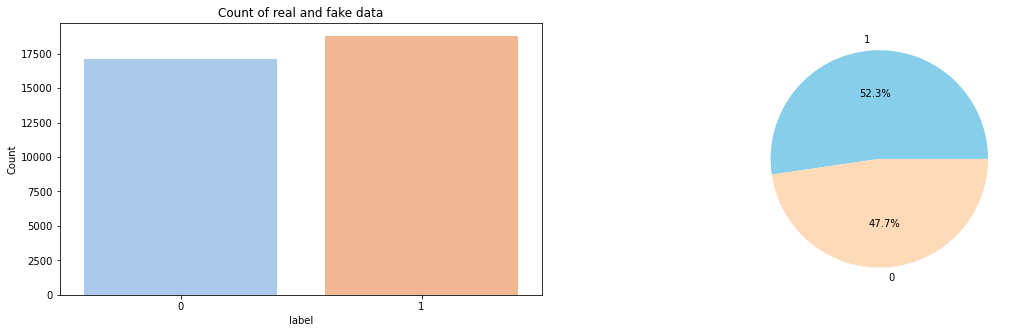

In [252]:
print(data["label"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(data.label,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("label")
g2 = plt.pie(data["label"].value_counts().values,explode=[0,0],labels=data.label.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

politicsNews       9007
worldnews          8126
News               7213
politics           5494
left-news          3562
Government News    1247
US_News             636
Middle-east         632
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

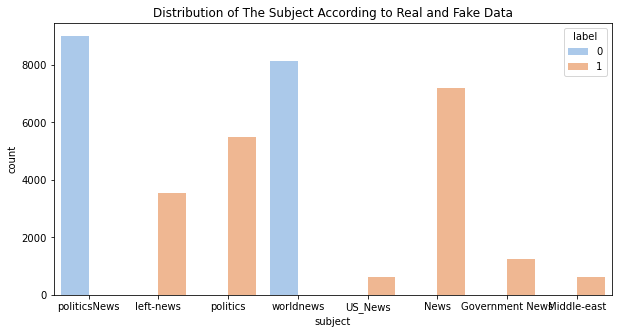

In [253]:
print(data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='label', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

# Data Preprocessing

In [254]:
data['text']= data['subject'] + " " + data['title'] + " " + data['text']
del data['title']
del data['subject']
del data['date']
data.head()

,text,label
0,politicsNews U.S. lawmakers seek missing infor...,0
1,"politicsNews Factbox: The nasty things Trump, ...",0
2,left-news ARMY OF ISIS Scientists Ready To Wag...,1
3,politics PA RESTAURANT Forced To CLOSE After I...,1
4,politicsNews Trump eyes top policy aide for co...,0


In [255]:
#nltk.download('punkt')

In [256]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#Removal of HTML Contents
def remove_html(text):
    return BeautifulSoup(text, "html.parser").get_text()
    
#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords 
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    swords = set(stopwords.words("english"))                      # conversion into set for fast searching
    text = [w for w in text if w not in swords]
    
    for word in text:
        word = lemmatizer.lemmatize(word) 
        final_text.append(word)
    #print('finished')
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text


In [257]:
data_before = data
data_before['text'][0]

'politicsNews U.S. lawmakers seek missing information in review of Monsanto weedkiller LONDON, (Reuters) - The chairman of a congressional committee has asked the U.S. National Institutes of Health (NIH) to explain why its National Cancer Institute (NCI) failed to publish data that showed no links between glyphosate and cancer. In a Tuesday letter seen by Reuters, U.S. Representative Trey Gowdy, who chairs the House Committee on Government and Oversight Reform (OGR), said he “is concerned about the new revelations” and is “seeking more information” about why the exculpatory results were not published by the NCI. Glyphosate is a key ingredient in Monsanto’s top-selling weedkiller Roundup. Gowdy’s letter to NIH Director Francis Collins follows a June report by Reuters which found that a senior scientist from the NCI knew that fresh data from a large research project known as the Agricultural Health Study (AHS) showed no links between glyphosate and cancer.  Draft scientific papers dating

In [258]:
#Apply function on text column
data['text'] = data['text'].apply(cleaning)

In [259]:
data_before['text'][0]

'politicsnews u lawmaker seek missing information review monsanto weedkiller london reuters chairman congressional committee asked u national institute health nih explain national cancer institute nci failed publish data showed link glyphosate cancer tuesday letter seen reuters u representative trey gowdy chair house committee government oversight reform ogr said concerned new revelation seeking information exculpatory result published nci glyphosate key ingredient monsanto top selling weedkiller roundup gowdy letter nih director francis collins follows june report reuters found senior scientist nci knew fresh data large research project known agricultural health study ahs showed link glyphosate cancer draft scientific paper dating containing data never published consequently information able taken account march review pesticide world health organization international agency research cancer iarc nih spokeswoman told reuters nih received gowdy letter responding directly committee aaron 

In [260]:
data['text'][0]

'politicsnews u lawmaker seek missing information review monsanto weedkiller london reuters chairman congressional committee asked u national institute health nih explain national cancer institute nci failed publish data showed link glyphosate cancer tuesday letter seen reuters u representative trey gowdy chair house committee government oversight reform ogr said concerned new revelation seeking information exculpatory result published nci glyphosate key ingredient monsanto top selling weedkiller roundup gowdy letter nih director francis collins follows june report reuters found senior scientist nci knew fresh data large research project known agricultural health study ahs showed link glyphosate cancer draft scientific paper dating containing data never published consequently information able taken account march review pesticide world health organization international agency research cancer iarc nih spokeswoman told reuters nih received gowdy letter responding directly committee aaron 

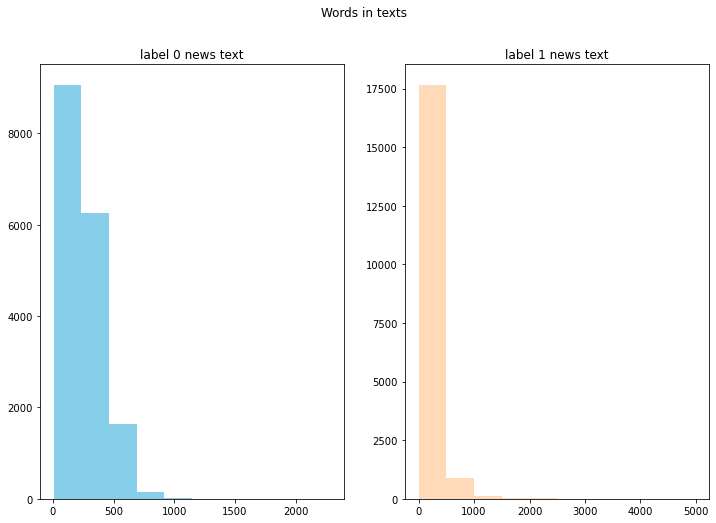

In [261]:
# Number of words in each text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('label 0 news text')
text_len=data[data['label']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('label 1 news text')
fig.suptitle('Words in texts')
plt.show()

# N-Gram Analysis

In [17]:
texts = ' '.join(data['text'])
string = texts.split(" ")

In [18]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

           word   count
0      (trump,)  119639
1       (said,)  106499
2          (u,)   63002
3      (state,)   50147
4  (president,)   46696


<AxesSubplot:xlabel='count', ylabel='word'>

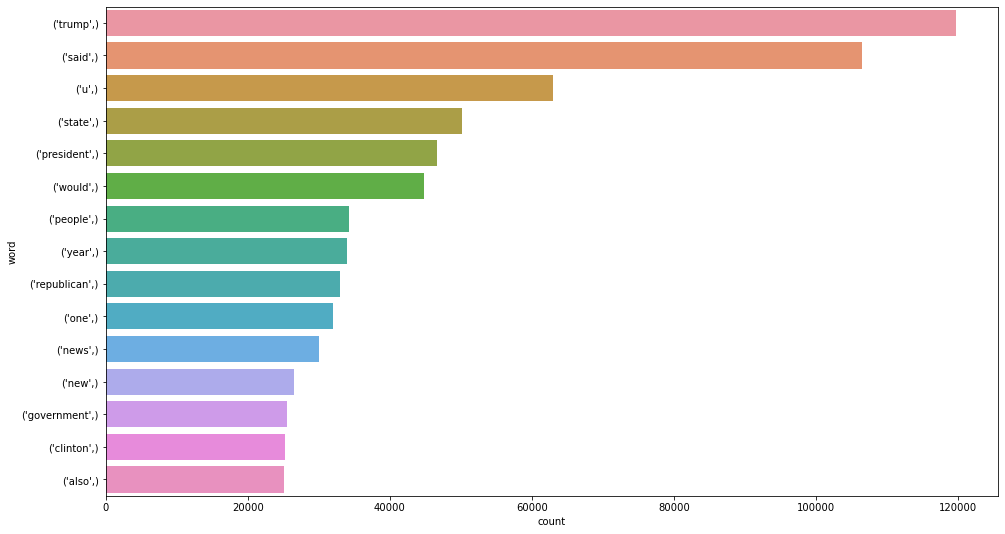

In [19]:
draw_n_gram(string,1)

                 word  count
0     (donald, trump)  20178
1     (united, state)  15124
2      (white, house)  13023
3  (hillary, clinton)   8200
4         (new, york)   7489


<AxesSubplot:xlabel='count', ylabel='word'>

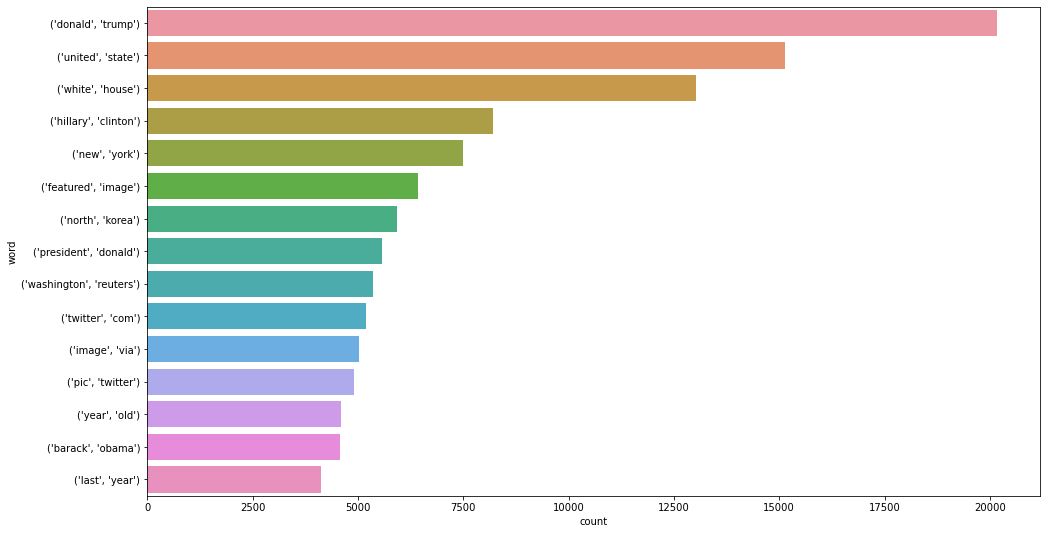

In [20]:
draw_n_gram(string,2)

                         word  count
0  (president, donald, trump)   5438
1         (pic, twitter, com)   4919
2      (featured, image, via)   4785
3  (president, barack, obama)   3093
4      (u, president, donald)   2096


<AxesSubplot:xlabel='count', ylabel='word'>

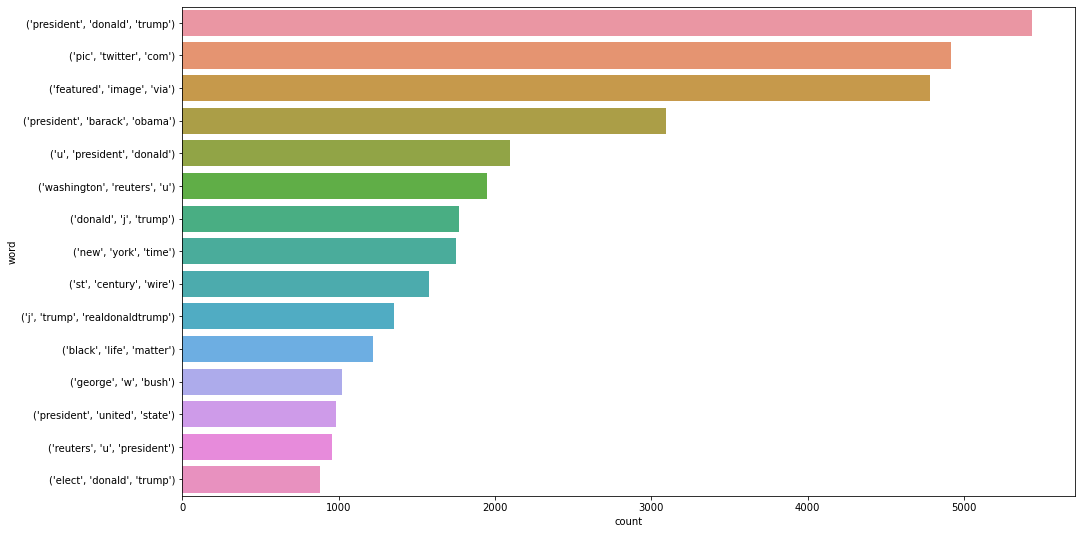

In [21]:
draw_n_gram(string,3)

# Splitting data

In [262]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], random_state=777)

In [263]:
X_train

10415    left news target cave customer boycott transge...
7537     worldnews new zealand labour leader say yet co...
1458     politics hillary pander black radio host attem...
24894    worldnews exclusive north korea rule negotiati...
33697    worldnews protest called porto court agrees wo...
                               ...                        
17369    politicsnews pentagon seek budget change boost...
28788    worldnews botswana court order government reco...
10879    politicsnews senior republican signal issue co...
26695    politicsnews big financial woe linger illinois...
15931    politics wikileaks email hillary camp call con...
Name: text, Length: 26937, dtype: object

In [266]:
type(X_train)

pandas.core.series.Series

# Tokenizing

In [227]:
# Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones
max_features = 10000
maxlen = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# Training

In [24]:
batch_size = 256
epochs = 10
embed_size = 100

In [25]:
# LSTM Model
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [27]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
74/74 [==============================] - 496s 7s/step - loss: 0.4838 - accuracy: 0.7440 - val_loss: 0.3430 - val_accuracy: 0.8524
Epoch 2/10
74/74 [==============================] - 511s 7s/step - loss: 0.3170 - accuracy: 0.8647 - val_loss: 0.2648 - val_accuracy: 0.8905
Epoch 3/10
74/74 [==============================] - 531s 7s/step - loss: 0.2870 - accuracy: 0.8749 - val_loss: 0.2380 - val_accuracy: 0.9001
Epoch 4/10
74/74 [==============================] - 539s 7s/step - loss: 0.3206 - accuracy: 0.8680 - val_loss: 0.3227 - val_accuracy: 0.8655
Epoch 5/10
74/74 [==============================] - 547s 7s/step - loss: 0.2391 - accuracy: 0.9068 - val_loss: 0.2165 - val_accuracy: 0.9223
Epoch 6/10
74/74 [==============================] - 571s 8s/step - loss: 0.1305 - accuracy: 0.9551 - val_loss: 0.0399 - val_accuracy: 0.9852
Epoch 7/10
74/74 [==============================] - 653s 9s/step - loss: 0.0461 - accuracy: 0.9832 - val_loss: 0.0398 - val_accuracy: 0.9853
Epoch 8/10
74

# Testing

In [28]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

842/842 [==============================] - 53s 63ms/step - loss: 0.0270 - accuracy: 0.9897
Accuracy of the model on Training Data is -  98.97167682647705 %
281/281 [==============================] - 18s 62ms/step - loss: 0.0342 - accuracy: 0.9874
Accuracy of the model on Testing Data is -  98.74165058135986 %


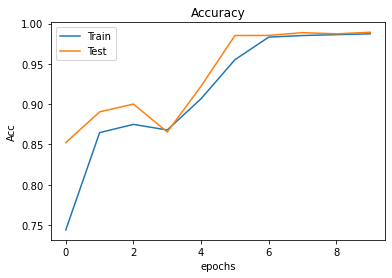

In [29]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

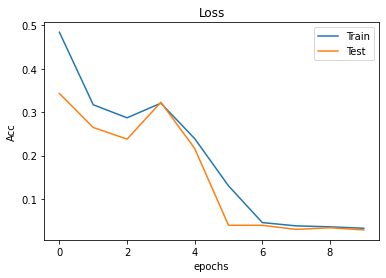

In [30]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

# Kaggle Testing part

In [338]:
test_df = pd.read_csv('D:/資料科學應用/project/project_data_test_revise.csv')
print(len(test_df))

8981


C:\Users\9hsun\anaconda3\envs\news_keras_env37\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [339]:
test_df.head()

,ID,title,text,subject,date,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150
0,0,Democrats' draft platform calls for reviews of...,WASHINGTON (Reuters) - The U.S. Democratic Par...,politicsNews,1-Jul-16,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Clinton expands lead over Trump to 13 points: ...,NEW YORK (Reuters) - Democratic presidential c...,politicsNews,5-Jul-16,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,SUNDAY SCREENING: CIA Secret Experiments (2008),"21st Century Wire says Every Sunday, our edito...",Middle-east,22-May-16,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,House Democratic leader Pelosi says intel pane...,WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,28-Mar-17,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,(VIDEO) UNBELIEVABLE! BLACK JUDGE BERATES VICT...,You won t believe this judge and how he berate...,Government News,12-Apr-15,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
# print(test_df.iloc[:,5].notnull().sum())
# indexNames = test_df[ test_df.iloc[:,5].notnull() ].index

367


In [270]:
# indexNames

Int64Index([   8,   52,   55,  137,  188,  193,  211,  221,  248,  271,
            ...
            8814, 8821, 8848, 8859, 8876, 8895, 8915, 8952, 8959, 8963],
           dtype='int64', length=367)

In [271]:
# test_df.drop(indexNames , inplace=True)
# print(len(test_df))

8618


In [272]:
# test_df.isnull().sum()

ID                 0
title              0
text               0
subject            9
date              28
                ... 
Unnamed: 146    8618
Unnamed: 147    8618
Unnamed: 148    8618
Unnamed: 149    8618
Unnamed: 150    8618
Length: 151, dtype: int64

In [273]:
# indexNames = test_df[ test_df.iloc[:,3].isnull() ].index
# indexNames

Int64Index([523, 1011, 2298, 3020, 3882, 4419, 5577, 6303, 7130], dtype='int64')

In [274]:
# test_df.drop(indexNames , inplace=True)
# print(len(test_df))

8609


In [317]:
# r = range(5,151)
# r = list(r)

# for i in range(len(r)):
#       r[i] = str(r[i])
# print(r)
# #print(list(str(r)))

['5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150']


In [319]:
# column_indices = list(range(5,151))
# new_names = r
# old_names = test_df.columns[column_indices]
# test_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [340]:
test_df = test_df.fillna(value = str(0))
print(len(test_df))
test_df.head()

8981


,ID,title,text,subject,date,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150
0,0,Democrats' draft platform calls for reviews of...,WASHINGTON (Reuters) - The U.S. Democratic Par...,politicsNews,1-Jul-16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Clinton expands lead over Trump to 13 points: ...,NEW YORK (Reuters) - Democratic presidential c...,politicsNews,5-Jul-16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,SUNDAY SCREENING: CIA Secret Experiments (2008),"21st Century Wire says Every Sunday, our edito...",Middle-east,22-May-16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,House Democratic leader Pelosi says intel pane...,WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,28-Mar-17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,(VIDEO) UNBELIEVABLE! BLACK JUDGE BERATES VICT...,You won t believe this judge and how he berate...,Government News,12-Apr-15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [341]:
test_df.isnull().sum()

ID              0
title           0
text            0
subject         0
date            0
               ..
Unnamed: 146    0
Unnamed: 147    0
Unnamed: 148    0
Unnamed: 149    0
Unnamed: 150    0
Length: 151, dtype: int64

In [342]:
test_df['text']= test_df['subject'] + " " + test_df['title'] + " " + test_df['text']
for i in range(5,151):
    test_df['text'] = test_df['text'] + " " + test_df.iloc[:,i]

del test_df['title']
del test_df['subject']
del test_df['date']
del test_df['ID']
print(len(test_df))

test_df.head()

8981


,text,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,...,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150
0,politicsNews Democrats' draft platform calls f...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,politicsNews Clinton expands lead over Trump t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Middle-east SUNDAY SCREENING: CIA Secret Exper...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,politicsNews House Democratic leader Pelosi sa...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Government News (VIDEO) UNBELIEVABLE! BLACK JU...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [343]:
test_df.drop(test_df.iloc[:, 1:147], inplace = True, axis = 1)
test_df.head()

,text
0,politicsNews Democrats' draft platform calls f...
1,politicsNews Clinton expands lead over Trump t...
2,Middle-east SUNDAY SCREENING: CIA Secret Exper...
3,politicsNews House Democratic leader Pelosi sa...
4,Government News (VIDEO) UNBELIEVABLE! BLACK JU...


In [344]:
test_df_before = test_df
test_df_before['text'][0]

"politicsNews Democrats' draft platform calls for reviews of trade deals WASHINGTON (Reuters) - The U.S. Democratic Party?�s 2016 policy platform calls for reviews of trade deals, wider health coverage through public programs such as Medicare, and federal investigations of fossil fuel companies accused of misleading shareholders on climate change, according to a draft version released on Friday. The committee drafting the platform last weekend approved the document, which spells out the party?�s policy priorities. It still must be formally adopted at the Democratic National Convention, to be held in Philadelphia in July.  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0"

In [345]:
test_df['text'] = test_df['text'].apply(cleaning)

In [346]:
test_df['text'][0]

'politicsnews democrat draft platform call review trade deal washington reuters u democratic party policy platform call review trade deal wider health coverage public program medicare federal investigation fossil fuel company accused misleading shareholder climate change according draft version released friday committee drafting platform last weekend approved document spell party policy priority still must formally adopted democratic national convention held philadelphia july'

In [347]:
len(test_df)

8981

In [348]:
# max_features = 10000
# maxlen = 300

# tokenizer = text.Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(test_df)
tokenized_kaggle = tokenizer.texts_to_sequences(test_df['text'])
test_df = sequence.pad_sequences(tokenized_kaggle, maxlen=maxlen)

In [349]:
test_df

array([[   0,    0,    0, ...,  334, 2789,  375],
       [   0,    0,    0, ..., 4863, 2081,  184],
       [   0,    0,    0, ...,  107,  268, 3599],
       ...,
       [   0,    0,    0, ...,   83, 1081, 2911],
       [   0,    0,    0, ...,  234,  422,   38],
       [   0,    0,    0, ..., 1597,  683, 2776]])

In [350]:
len(test_df)

8981

In [351]:
prediction_LSTM = model.predict_classes(test_df)

In [352]:
prediction_LSTM

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [353]:
pd.DataFrame(prediction_LSTM).to_csv("D:/資料科學應用/project/prediction_LSTM.csv")

In [354]:
model.save('LSTM.h5')